<a href="https://www.kaggle.com/code/chloemaurel/transfer-learning?scriptVersionId=122864109" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# General Information

This notebook aim to test the performance of transfer learning on this hand-writting digit dataset. 

Two well-known model will be tested: VGG16 and ResnNet50.
ResNet50 is known for its faster 

To start, we will implement only feature extraction from both model and evaluate using the accuracy and f1 score metric.



# Importing Libraries

In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2 as cv
import tensorflow as tf
import keras
from keras import backend as K
from tensorflow.keras.utils import img_to_array
from keras.applications.resnet import ResNet50
from keras.applications.resnet import preprocess_input
from keras.layers import Conv2D, MaxPooling2D, Dense, Input, Flatten, Dropout, UpSampling2D, GlobalAveragePooling2D
from keras.layers import RandomFlip, RandomRotation, RandomZoom
from keras.models import Model
from keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import pickle
from tensorflow.keras.models import Sequential

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/resnet-v2/tensorflow2/50-classification/2/saved_model.pb
/kaggle/input/resnet-v2/tensorflow2/50-classification/2/variables/variables.index
/kaggle/input/resnet-v2/tensorflow2/50-classification/2/variables/variables.data-00000-of-00001
/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [54]:
train_csv = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
test_csv = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")
train_csv.head(3)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
test_csv.head(3)

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
num_classes = len(train_csv['label'].unique())
num_classes

10

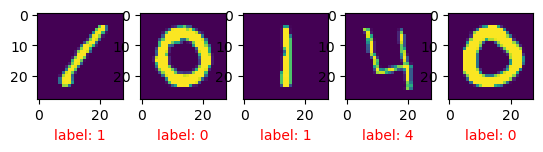

In [4]:
IMG_SIZE = (28,28,1)
# Sample digit image
sample_images = train_csv.iloc[0:5,1:].values.reshape((-1,)+IMG_SIZE)
fig, axs = plt.subplots(1, sample_images.shape[0])
for i,img in enumerate(sample_images):
    axs[i].imshow(img)
    axs[i].set_xlabel(f'label: {train_csv.iloc[i,0]}')
    axs[i].xaxis.label.set_color('red')

## Preparation of Data

- X : from 28 * 28 grey-scale pixels to 32 * 32 RGB-scale pixels 
- y: from a column of numbers to an array of one-hot-encoding.

In [5]:
# Preprocessing Data
X = train_csv.iloc[:,1:].values.reshape((-1,)+(28,28,1)).astype(np.float32)
list = []
for i in range(len(X)):
    X_rgb = cv.cvtColor(X[i], cv.COLOR_GRAY2RGB)
    X_rgb = cv.resize(X_rgb, (75,75))
    list.append(X_rgb)
X_rgb = np.array(list)
# Normalization
X_rgb /= 255

y = train_csv.iloc[:,0].astype(np.int32)
y = pd.get_dummies(y)

print(f'X shape: {format(X_rgb.shape)}')
print(f'y shape: {format(y.shape)}')

X shape: (42000, 75, 75, 3)
y shape: (42000, 10)


In [55]:
X_submission = test_csv.iloc[:,:].values.reshape((-1,)+(28,28,1)).astype(np.float32)
list = []
for i in range(len(X_submission)):
    X_t = cv.cvtColor(X_submission[i], cv.COLOR_GRAY2RGB)
    X_t = cv.resize(X_t, (75,75))
    list.append(X_t)
X_submission = np.array(list)
# Normalization
X_submission /= 255

print(f'X test shape: {format(X_submission.shape)}')

X test shape: (28000, 75, 75, 3)


In [47]:
# Splitting Dataset
X_train, X_val, y_train, y_val = train_test_split(X_rgb,y,test_size=0.2)
X_val, X_test, y_val, y_test = train_test_split(X_val,y_val,test_size=0.5)

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'y_val shape: {y_val.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (33600, 75, 75, 3)
y_train shape: (33600, 10)
X_val shape: (4200, 75, 75, 3)
y_val shape: (4200, 10)
X_test shape: (4200, 75, 75, 3)
y_test shape: (4200, 10)


In [46]:
# Splitting Dataset
X_train1, X_val1, y_train1, y_val1 = train_test_split(X_rgb,y,test_size=0.2)
X_val1, X_test1, y_val1, y_test1 = train_test_split(X_val1,y_val1,test_size=0.4)

print(f'X_train shape: {X_train1.shape}')
print(f'y_train shape: {y_train1.shape}')
print(f'X_val shape: {X_val1.shape}')
print(f'y_val shape: {y_val1.shape}')
print(f'X_test shape: {X_test1.shape}')
print(f'y_test shape: {y_test1.shape}')

X_train shape: (33600, 75, 75, 3)
y_train shape: (33600, 10)
X_val shape: (5040, 75, 75, 3)
y_val shape: (5040, 10)
X_test shape: (3360, 75, 75, 3)
y_test shape: (3360, 10)


### X_train and X_val transformed into tensors

In [48]:
X_train = tf.convert_to_tensor(X_train)
X_val = tf.convert_to_tensor(X_val)
X_test = tf.convert_to_tensor(X_test)
y_train = tf.convert_to_tensor(y_train)
y_val = tf.convert_to_tensor(y_val)
y_test = tf.convert_to_tensor(y_test)

In [9]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# Loading pre-trained models (ResNet50/MobileNetV2/VGG16)

## ResNet50

### Feature exctraction

In [10]:
model = Sequential()

model.add(tf.keras.applications.resnet50.ResNet50(input_shape = (75, 75, 3), 
                                include_top = False, 
                                weights = 'imagenet'))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.layers[0].trainable = False

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy', f1_m])

94765736/94765736 [==============================] - 3s 0us/step


In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 3, 3, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 128)               2359424   
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 25,948,426
Trainable params: 2,360,714
Non-trainable params: 23,587,712
_________________________________________________________________


In [12]:
history = model.fit(X_train,y_train, validation_data=(X_val,y_val), epochs=6)

Epoch 1/6
1050/1050 [==============================] - 310s 293ms/step - loss: 0.8055 - accuracy: 0.8113 - f1_m: 0.6605 - val_loss: 0.3984 - val_accuracy: 0.9007 - val_f1_m: 0.8823
Epoch 2/6
1050/1050 [==============================] - 307s 292ms/step - loss: 0.3240 - accuracy: 0.9180 - f1_m: 0.9095 - val_loss: 0.2619 - val_accuracy: 0.9340 - val_f1_m: 0.9309
Epoch 3/6
1050/1050 [==============================] - 330s 315ms/step - loss: 0.2323 - accuracy: 0.9387 - f1_m: 0.9361 - val_loss: 0.2039 - val_accuracy: 0.9467 - val_f1_m: 0.9451
Epoch 4/6
1050/1050 [==============================] - 347s 331ms/step - loss: 0.1878 - accuracy: 0.9492 - f1_m: 0.9474 - val_loss: 0.1755 - val_accuracy: 0.9533 - val_f1_m: 0.9538
Epoch 5/6
1050/1050 [==============================] - 317s 302ms/step - loss: 0.1600 - accuracy: 0.9554 - f1_m: 0.9548 - val_loss: 0.1582 - val_accuracy: 0.9560 - val_f1_m: 0.9556
Epoch 6/6
1050/1050 [==============================] - 316s 301ms/step - loss: 0.1410 - accurac

In [13]:
pickle.dump(model, open('model_resnet50_feature_extraction.sav', 'wb'))

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......flatten
.........vars
......functional
.........layers
............activation
...............vars
............activation_1
...............vars
............activation_10
...............vars
............activation_11
...............vars
............activation_12
...............vars
............activation_13
...............vars
............activation_14
...............vars
............activation_15
...............vars
............activation_16
...............vars
............activation_17
...............vars
............activation_18
...............vars
............activation_19
...............vars
............activation_2
...............vars
............activation_20
...............vars
............activation_21
...............vars
............activation_22
...............vars
............activation

In [ ]:
history = model.fit(X_train,y_train, validation_data=(X_val,y_val), epochs=5)

In [52]:
model.evaluate(X_test,y_test)

132/132 [==============================] - 35s 268ms/step - loss: 0.1396 - accuracy: 0.9617 - f1_m: 0.9616


[0.13963495194911957, 0.9616666436195374, 0.9615893959999084]

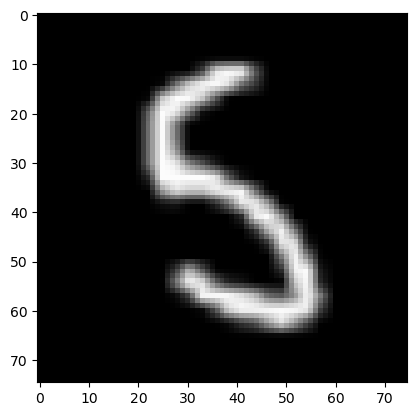

In [49]:
plt.imshow(np.array(X_test[4]), interpolation='nearest')
plt.show()

In [51]:
np.array(y_test[4])

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0], dtype=uint8)

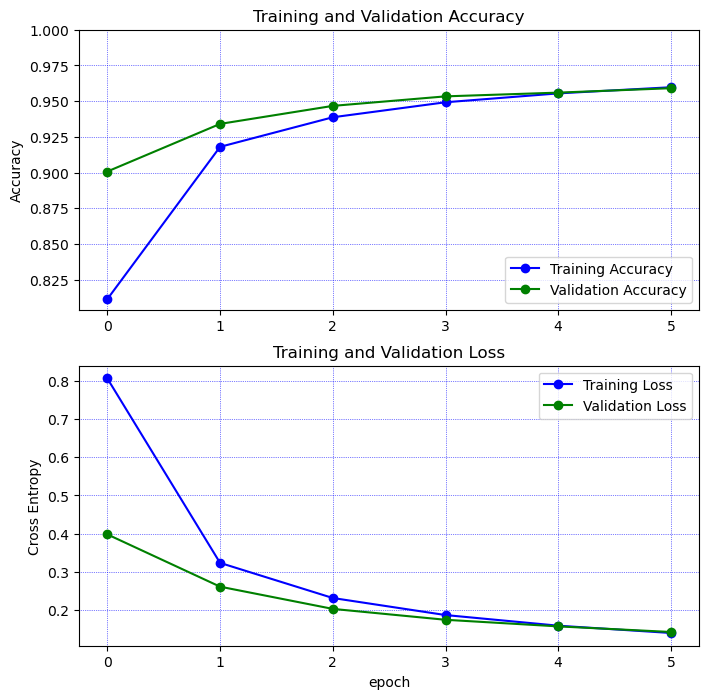

In [15]:
acc_res50_feature = history.history['accuracy']
val_acc_res50_feature = history.history['val_accuracy']

loss_res50_feature = history.history['loss']
val_loss_res50_feature = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.grid(color='b', linestyle='dotted', linewidth=0.5)
plt.plot(acc_res50_feature, 'o-',label='Training Accuracy', color='b')
plt.plot(val_acc_res50_feature, 'o-',label='Validation Accuracy', color='g')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.grid(color='b', linestyle='dotted', linewidth=0.5)
plt.plot(loss_res50_feature, 'o-',label='Training Loss', color='b')
plt.plot(val_loss_res50_feature, 'o-',label='Validation Loss', color='g')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Submission of ResNet50 result

In [56]:
result_test = model.predict(X_submission)

875/875 [==============================] - 230s 262ms/step


In [67]:
result = np.argmax(result_test,1)
result

array([2, 0, 9, ..., 3, 9, 2])

In [57]:
submission = pd.read_csv('/kaggle/input/digit-recognizer/sample_submission.csv')
submission

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
27995,27996,0
27996,27997,0
27997,27998,0
27998,27999,0


In [61]:
submission['Label'] = np.argmax(result_test,1)
submission

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9


In [64]:
submission.to_csv('submission_resnet50.csv', index=False)

## Displaying Test images and predicted label

In [ ]:
X_tzest[0]

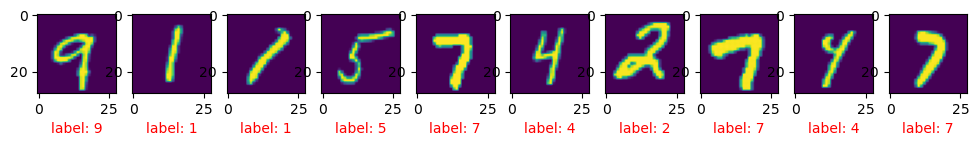

In [72]:
IMG_SIZE = (28,28,1)
# Sample digit image
sample_images = test_csv.iloc[20:30,0:].values.reshape((-1,)+IMG_SIZE)
fig, axs = plt.subplots(1, sample_images.shape[0], figsize=(12,12))
for i,img in enumerate(sample_images):
    axs[i].imshow(img)
    axs[i].set_xlabel(f'label: {result[i + 20]}')
    axs[i].xaxis.label.set_color('red')

## Confusion Matrix - 0.966 acc

In [91]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
accuracies = []
def confusion(y_true,y_pred):
    fig = plt.figure(figsize=(8,8)) # Set Figure
    mat = confusion_matrix(y_true, y_pred) # Confusion matrix

    # Plot Confusion matrix
    sns.set(font_scale=1)
    sns.heatmap(mat.T, square=True, annot=True, cbar=True, cmap="crest",fmt="d")
    plt.title("Confusion Matrix")
    plt.xlabel('Predicted Values')
    plt.ylabel('True Values');
    plt.show();
    print(accuracy_score(y_true,y_pred))
    accuracies.append(accuracy_score(y_true,y_pred))

In [80]:
y_pred = model.predict(X_test)

132/132 [==============================] - 39s 287ms/step


In [82]:
np.argmax(y_pred,1)

array([2, 7, 6, ..., 7, 7, 5])

In [85]:
np.argmax(np.array(y_test),1)

array([2, 7, 6, ..., 7, 7, 5])

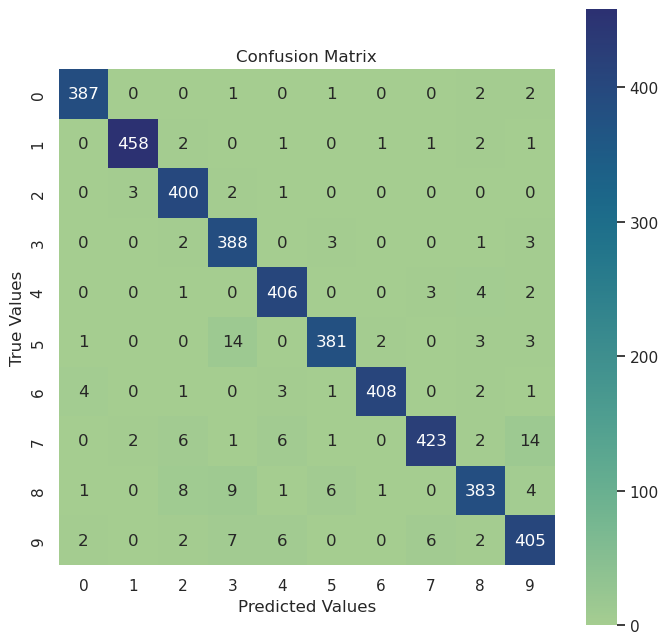

0.9616666666666667


In [92]:
confusion(np.argmax(np.array(y_test),1),np.argmax(y_pred,1))

## VGG16

In [93]:
model_vgg16 = Sequential()

model_vgg16.add(tf.keras.applications.vgg16.VGG16(input_shape = (75, 75, 3), 
                                include_top = False, 
                                weights = 'imagenet'))

model_vgg16.add(Flatten())
model_vgg16.add(Dense(128, activation='relu'))
model_vgg16.add(Dense(10, activation='softmax'))

model_vgg16.layers[0].trainable = False

model_vgg16.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy', f1_m])

58889256/58889256 [==============================] - 2s 0us/step


In [94]:
model_vgg16.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               262272    
                                                                 
 dense_3 (Dense)             (None, 10)                1290      
                                                                 
Total params: 14,978,250
Trainable params: 263,562
Non-trainable params: 14,714,688
_________________________________________________________________


In [95]:
history_vgg16 = model_vgg16.fit(X_train,y_train, validation_data=(X_val,y_val), epochs=6)

Epoch 1/6
1050/1050 [==============================] - 756s 719ms/step - loss: 0.5748 - accuracy: 0.8830 - f1_m: 0.7665 - val_loss: 0.2329 - val_accuracy: 0.9433 - val_f1_m: 0.9359
Epoch 2/6
1050/1050 [==============================] - 746s 711ms/step - loss: 0.1732 - accuracy: 0.9583 - f1_m: 0.9550 - val_loss: 0.1423 - val_accuracy: 0.9643 - val_f1_m: 0.9641
Epoch 3/6
1050/1050 [==============================] - 746s 711ms/step - loss: 0.1184 - accuracy: 0.9687 - f1_m: 0.9687 - val_loss: 0.1086 - val_accuracy: 0.9717 - val_f1_m: 0.9715
Epoch 4/6
1050/1050 [==============================] - 745s 709ms/step - loss: 0.0929 - accuracy: 0.9754 - f1_m: 0.9750 - val_loss: 0.0940 - val_accuracy: 0.9731 - val_f1_m: 0.9739
Epoch 5/6
1050/1050 [==============================] - 751s 716ms/step - loss: 0.0772 - accuracy: 0.9790 - f1_m: 0.9789 - val_loss: 0.0844 - val_accuracy: 0.9757 - val_f1_m: 0.9764
Epoch 6/6
1050/1050 [==============================] - 745s 710ms/step - loss: 0.0670 - accurac

In [96]:
pickle.dump(model_vgg16, open('model_vgg16_feature_extraction.sav', 'wb'))

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......flatten
.........vars
......functional
.........layers
............conv2d
...............vars
..................0
..................1
............conv2d_1
...............vars
..................0
..................1
............conv2d_10
...............vars
..................0
..................1
............conv2d_11
...............vars
..................0
..................1
............conv2d_12
...............vars
..................0
..................1
............conv2d_2
...............vars
..................0
..................1
............conv2d_3
...............vars
..................0
..................1
............conv2d_4
...............vars
..................0
..................1
............conv2d_5
...............vars
..................0
..................1
............conv2d_6
..

In [70]:
loaded_model_vgg16 = pickle.load(open('model_vgg16_feature_extraction.sav', 'rb'))

Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-03-20 09:51:56        11897
variables.h5                                   2023-03-20 09:51:56     59980880
metadata.json                                  2023-03-20 09:51:56           64
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......flatten
.........vars
......functional
.........layers
............conv2d
...............vars
..................0
..................1
............conv2d_1
...............vars
..................0
..................1
............conv2d_10
...............vars
..................0
..................1
............conv2d_11
...............vars
..................0
..................1
............conv2d_12
...............vars
..................0
..................

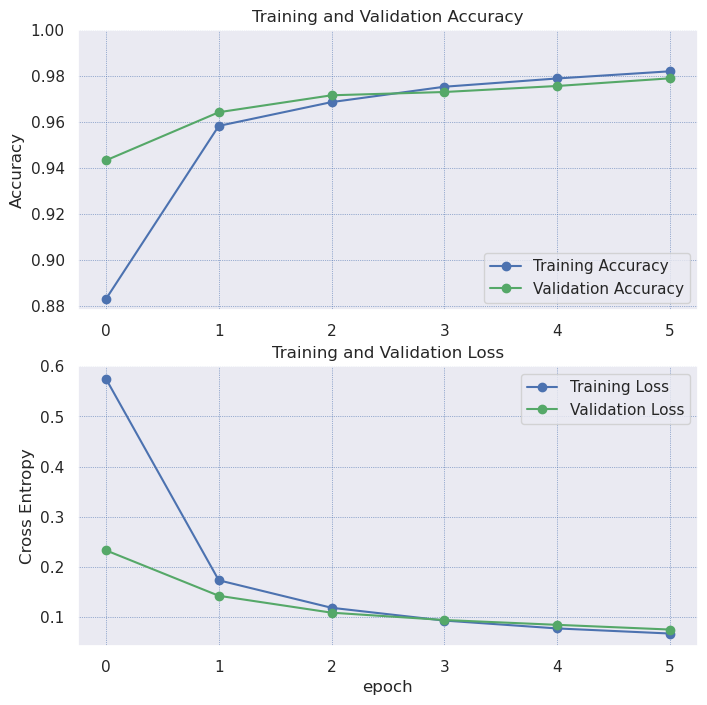

In [98]:
acc_vgg16 = history_vgg16.history['accuracy']
val_acc_vgg16 = history_vgg16.history['val_accuracy']

loss_vgg16 = history_vgg16.history['loss']
val_loss_vgg16 = history_vgg16.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.grid(color='b', linestyle='dotted', linewidth=0.5)
plt.plot(acc_vgg16, 'o-',label='Training Accuracy', color='b')
plt.plot(val_acc_vgg16, 'o-',label='Validation Accuracy', color='g')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.grid(color='b', linestyle='dotted', linewidth=0.5)
plt.plot(loss_vgg16, 'o-',label='Training Loss', color='b')
plt.plot(val_loss_vgg16, 'o-',label='Validation Loss', color='g')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Submitting VGG16 result

In [99]:
result_test_vgg16 = model_vgg16.predict(X_submission)

875/875 [==============================] - 555s 634ms/step


In [100]:
result_vgg16 = np.argmax(result_test_vgg16,1)
result_vgg16

array([2, 0, 9, ..., 3, 9, 2])

In [101]:
submission = pd.read_csv('/kaggle/input/digit-recognizer/sample_submission.csv')
submission

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
27995,27996,0
27996,27997,0
27997,27998,0
27998,27999,0


In [102]:
submission['Label'] = result_vgg16
submission

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9


In [103]:
submission.to_csv('submission_vgg16.csv', index=False)

## Confusion Matrix

In [104]:
y_pred = model_vgg16.predict(X_test)

132/132 [==============================] - 84s 634ms/step


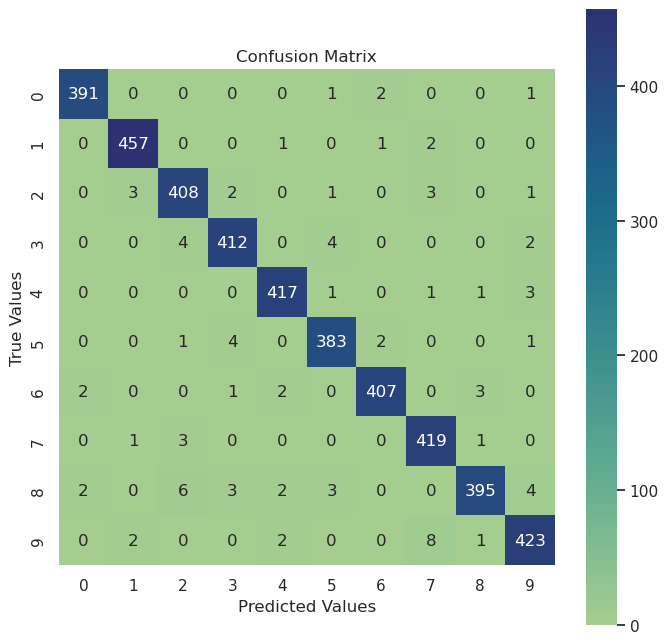

0.979047619047619


In [105]:
confusion(np.argmax(np.array(y_test),1),np.argmax(y_pred,1))